<a href="https://colab.research.google.com/github/rawatpremsingh999/tensorflow-coursera/blob/master/Exercise_8_Multi_Class_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experimenting on Sign Language MNIST data

**Download the data from kaggle**

It is a CSV file that contain label and corresponding pixel values of image.

The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255. The original hand gesture image data represented multiple users repeating the gesture against different backgrounds.

URL: https://www.kaggle.com/datamunge/sign-language-mnist

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/tmp/"

In [2]:
#changing the working directory
%cd /tmp/

/tmp


Note:
(1) First, download json file from your kaggle profile. <br>
**( Your Profile > Edit Profile > API section > Create New API Token)**. <br>
It downloads a json file.<br>

(2) upload json file in the collab directory i.e. /tmp/

In [3]:
!chmod 600 /tmp/kaggle.json # change access specifier
!kaggle datasets download -d datamunge/sign-language-mnist # copy from Copy API command at kaggle dataset

 86% 54.0M/62.6M [00:00<00:00, 57.4MB/s]
100% 62.6M/62.6M [00:00<00:00, 158MB/s] 


In [4]:
# extract zip file
import zipfile

local_zip = '/tmp/sign-language-mnist.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/sign-language-mnist')
zip_ref.close()

In [5]:
# import necessary libraries
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os import getcwd

Get train and test csv file from tmp folder

In [6]:
path_sign_mnist_train = f"{getcwd()}/../tmp/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv"
path_sign_mnist_test = f"{getcwd()}/../tmp/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv"

Prepare well formated data from csv format

In [7]:
def get_data(filename):
  # You will need to write code that will read the file passed
  # into this function. The first line contains the column headers
  # so you should ignore it
  # Each successive line contains 785 comma separated values between 0 and 255
  # The first value is the label
  # The rest are the pixel values for that picture
  # The function will return 2 np.array types. One with all the labels
  # One with all the images
  #
  # Tips: 
  # If you read a full line (as 'row') then row[0] has the label
  # and row[1:785] has the 784 pixel values
  # Take a look at np.array_split to turn the 784 pixels into 28x28
  # You are reading in strings, but need the values to be floats
  # Check out np.array().astype for a conversion
    with open(filename) as training_file:
      data = csv.reader(training_file)
      images, labels = [], []
      i = 0
      for row in data:
        if i == 0:
          i += 1
          continue
        labels.append(row[0])
        pixels = np.array(row[1:785]).reshape(28,28)
        images.append(pixels)
    images = np.array(images).astype(float)
    labels = np.array(labels).astype(float)
    return images, labels

In [8]:
training_images, training_labels = get_data(path_sign_mnist_train)
testing_images, testing_labels = get_data(path_sign_mnist_test)

# shape of training and testing data
print(training_images.shape)
print(training_labels.shape)
print(testing_images.shape)
print(testing_labels.shape)

(27455, 28, 28)
(27455,)
(7172, 28, 28)
(7172,)


#### Visualisation of images

In [9]:
import matplotlib.pyplot as plt
import random

In [10]:
# Map number to English Alphabet
int_to_alpha_dict = {}

i = 0
for i in range(ord('A'),ord('Z')+1):
  int_to_alpha_dict[i] = chr(i)

print(int_to_alpha_dict)

{65: 'A', 66: 'B', 67: 'C', 68: 'D', 69: 'E', 70: 'F', 71: 'G', 72: 'H', 73: 'I', 74: 'J', 75: 'K', 76: 'L', 77: 'M', 78: 'N', 79: 'O', 80: 'P', 81: 'Q', 82: 'R', 83: 'S', 84: 'T', 85: 'U', 86: 'V', 87: 'W', 88: 'X', 89: 'Y', 90: 'Z'}


**Training Images**

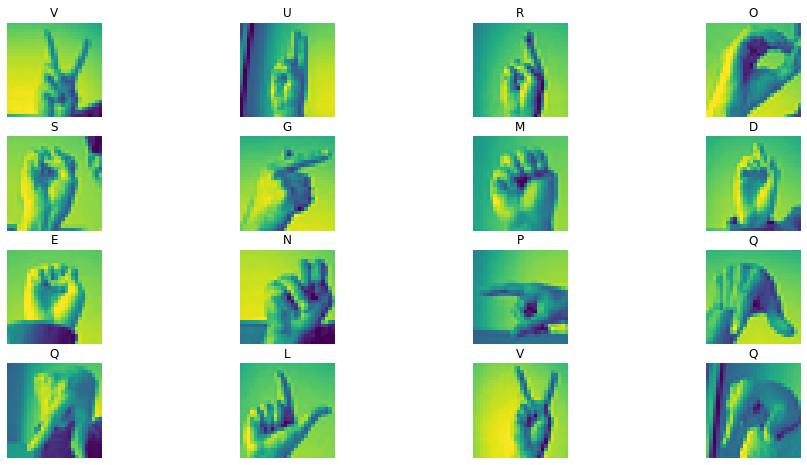

In [11]:
pix = random.choices(range(0,training_images.shape[0]-1),k=16)

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(16, 8)
for i, img in enumerate(pix):
  sp = plt.subplot(4, 4, i + 1)
  sp.axis('Off')
  plt.imshow(training_images[img])
  plt.title(int_to_alpha_dict[int(training_labels[img])+65])
plt.show()

**Testing Images**

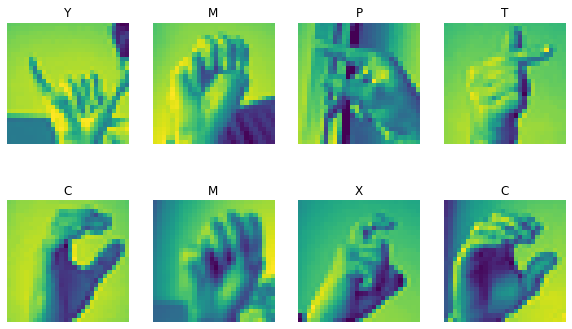

In [12]:
pix = random.choices(range(0,testing_images.shape[0]-1),k=8)

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(10, 6)
for i, img in enumerate(pix):
  sp = plt.subplot(2, 4, i + 1)
  sp.axis('Off')
  plt.imshow(testing_images[img])
  plt.title(int_to_alpha_dict[int(testing_labels[img])+65])
plt.show()

**Expand dimension**
convet 3-D to 4-D

In [13]:
# In this section you will have to add another dimension to the data
# So, for example, if your array is (10000, 28, 28)
# You will need to make it (10000, 28, 28, 1)
# Hint: np.expand_dims

training_images = np.expand_dims(training_images,axis = 3) # Your Code Here
testing_images = np.expand_dims(testing_images,axis = 3) # Your Code Here

# Keep These
print(training_images.shape)
print(testing_images.shape)

(27455, 28, 28, 1)
(7172, 28, 28, 1)


In [14]:
# Create an ImageDataGenerator and do Image Augmentation
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range = 0.2,
    fill_mode='nearest',
    horizontal_flip = True
    )

validation_datagen = ImageDataGenerator(rescale=1./255.)


train_datagen  = train_datagen.flow(x = training_images,y = training_labels)

validation_datagen = validation_datagen.flow(x = testing_images, y = testing_labels)

In [15]:
# stopping criteria
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if (logs.get('accuracy')>0.9):
      print("\nAccuracy reached at more than 90% so cancelling training!!!")
      self.model.stop_training = True

callback = myCallback()

In [19]:
# Define the model
# Use no more than 2 Conv2D and 2 MaxPooling2D
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,3,activation='relu',input_shape = (28,28,1)),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(128,3,activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(26,activation='softmax')
    ])

# Compile Model. 
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

# Train the Model
history = model.fit(
    train_datagen,
    batch_size = 16,
    epochs = 100,
    validation_data = validation_datagen,
    verbose = 1,
    callbacks = [callback])

model.evaluate(testing_images, testing_labels, verbose=0)

Epoch 1/100
858/858 [==============================] - 10s 11ms/step - loss: 3.0475 - accuracy: 0.0913 - val_loss: 1.9269 - val_accuracy: 0.3806
Epoch 2/100
858/858 [==============================] - 9s 11ms/step - loss: 2.2426 - accuracy: 0.2942 - val_loss: 1.3770 - val_accuracy: 0.5322
Epoch 3/100
858/858 [==============================] - 9s 11ms/step - loss: 1.8300 - accuracy: 0.4239 - val_loss: 1.0881 - val_accuracy: 0.6485
Epoch 4/100
858/858 [==============================] - 9s 10ms/step - loss: 1.5444 - accuracy: 0.5031 - val_loss: 0.9381 - val_accuracy: 0.6905
Epoch 5/100
858/858 [==============================] - 9s 10ms/step - loss: 1.3848 - accuracy: 0.5548 - val_loss: 0.8024 - val_accuracy: 0.7292
Epoch 6/100
858/858 [==============================] - 9s 11ms/step - loss: 1.2624 - accuracy: 0.5892 - val_loss: 0.6678 - val_accuracy: 0.7737
Epoch 7/100
858/858 [==============================] - 9s 11ms/step - loss: 1.1278 - accuracy: 0.6285 - val_loss: 0.6112 - val_accuracy

[668.1972045898438, 0.4552426040172577]

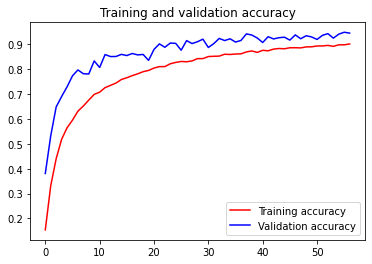

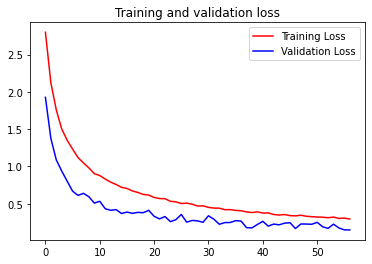

In [20]:
# Plot the chart for accuracy and loss on both training and validation
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy'] # Your Code Here
val_acc = history.history['val_accuracy'] # Your Code Here
loss = history.history['loss'] # Your Code Here
val_loss = history.history['val_loss'] # Your Code Here

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()